In [41]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from collections import deque
%matplotlib inline

In [79]:
objpoints = []  # 3d points in real world space
imgpoints = []  # 2d points in image plane.

def calibration(nx: int = 9, ny: int = 6, calibration_Dir: str = 'camera_cal/calibration*.jpg'):
    objp = np.zeros((ny * nx, 3), np.float32)
    objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

    images = glob.glob(calibration_Dir)

    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
            f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
            ax1.imshow(cv2.cvtColor(mpimg.imread(fname), cv2.COLOR_BGR2RGB))
            ax1.set_title('Original Image', fontsize=18)
            ax2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            ax2.set_title('With Corners', fontsize=18)


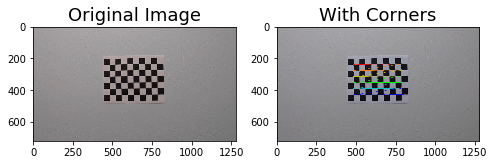

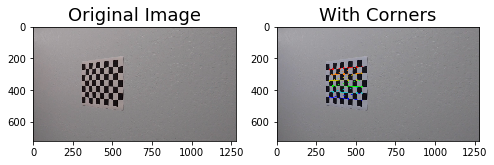

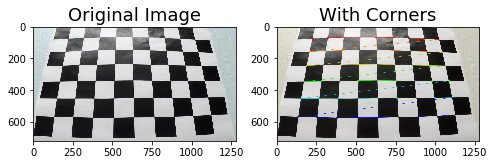

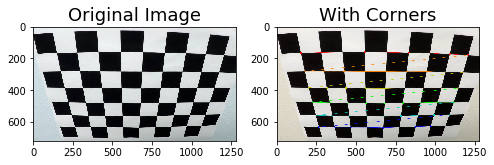

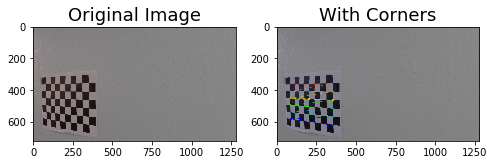

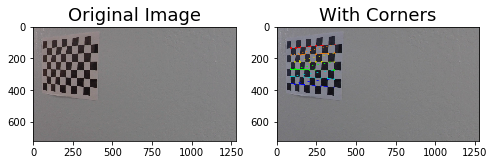

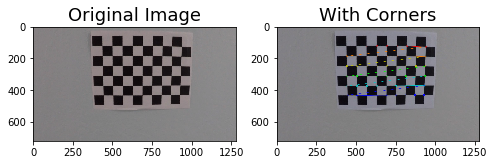

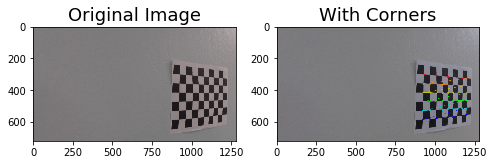

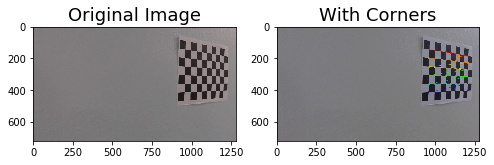

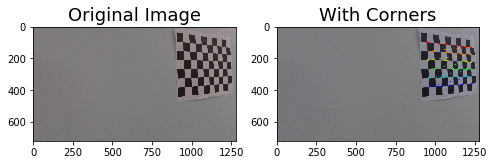

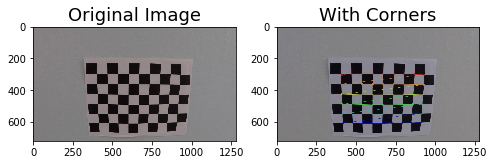

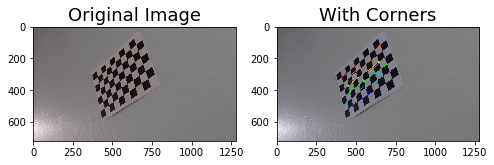

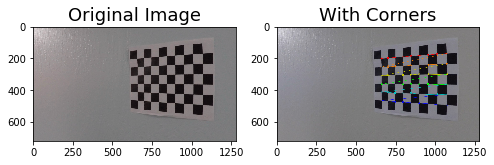

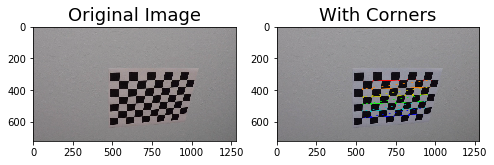

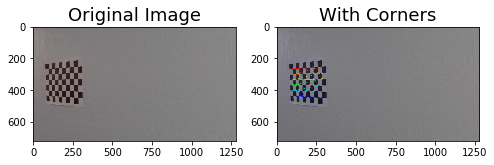

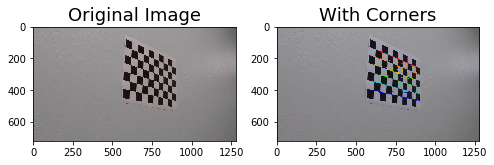

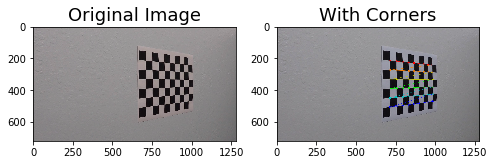

In [44]:
calibration()

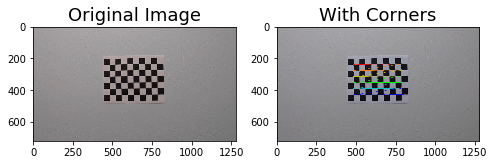

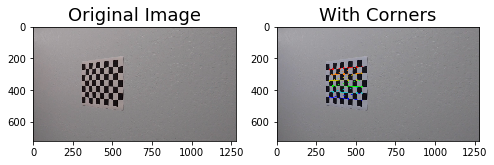

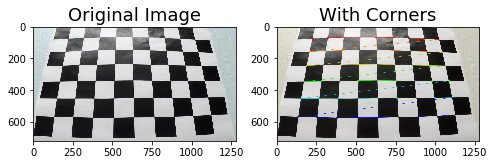

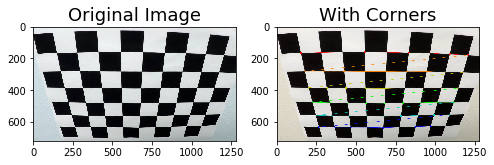

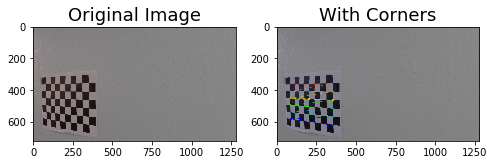

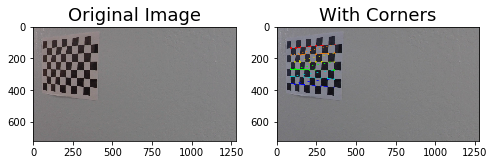

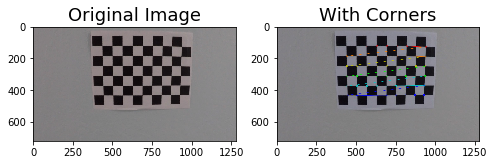

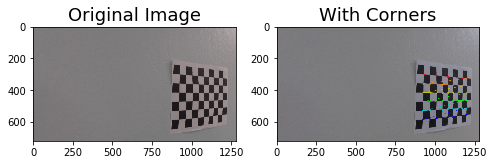

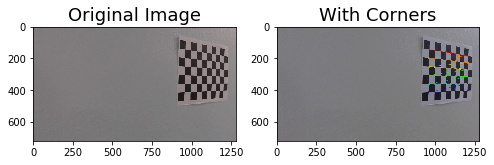

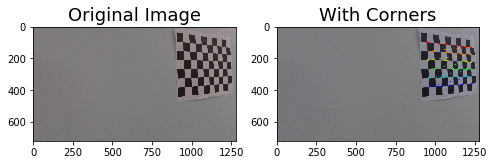

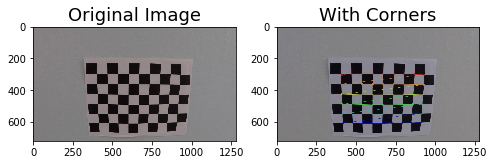

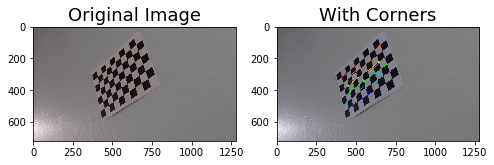

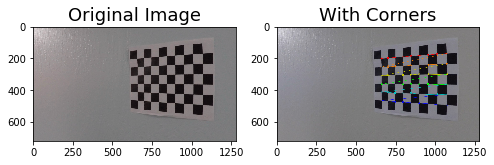

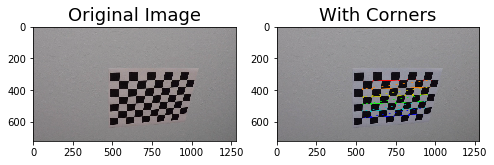

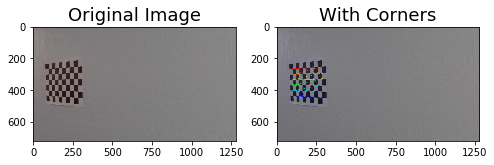

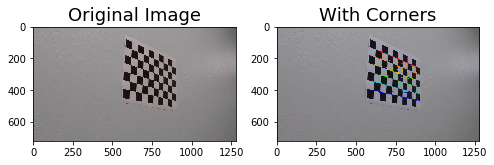

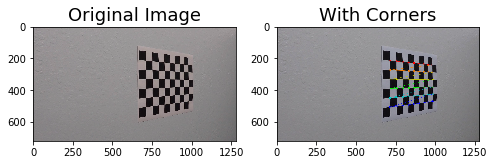

In [34]:
# Remove distortion from images
def undistort(img_input, show=True):
    img = cv2.imread(img_input)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (img.shape[1],img.shape[0]), None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    if show:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,5))
        ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax1.set_title('Original Image', fontsize=16)
        ax2.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
        ax2.set_title('Undistorted Image', fontsize=16)
    else:
        return undist

In [36]:
test_Images = glob.glob('test_images/test*.jpg')
for img in test_Images:
    undistort(img_input=img)


In [37]:
def calculate_sobel(img: np.array, min_thresh: int = 20, max_thresh: int = 100, show: bool = True):
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= min_thresh) & (scaled_sobel <= max_thresh)] = 1
    if show:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 5))
        ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax1.set_title('Original Image', fontsize=16)
        ax2.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
        ax2.set_title('Undistorted Image', fontsize=16)
    else:
        return sxbinary


In [38]:
def mask_image(img: np.array):
    # Define shape for later birds-eye-view
    """
    :type img: image (numpy array)
    """
    sw_x = img.shape[1] * .01
    sw_y = img.shape[0]
    nw_x = int(img.shape[1] * .35)
    nw_y = int(img.shape[0] * .65)
    ne_x = int(img.shape[1] * .65)
    ne_y = int(img.shape[0] * .65)
    se_x = int(img.shape[1] + (img.shape[1] * .1))
    se_y = int(img.shape[0])

    vertices = np.array([[(sw_x, sw_y),
                          (nw_x, nw_y),
                          (ne_x, ne_y),
                          (se_x, se_y)]], dtype=np.int32)
    mask = np.zeros_like(img)

    # defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    # filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    # returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


In [39]:
def increase_contrast(img, masked_arr_min=0, masked_arr_max=255, bins=256, hist_min=0, hist_max=256, ):
    """
    :type hist_max: int
    :type hist_min: int
    :type bins: int
    :type masked_arr_max: int
    :type masked_arr_min: int
    """
    equ = cv2.equalizeHist(img)
    hist, bins = np.histogram(equ.flatten(), bins, [hist_min, hist_max])
    cdf = hist.cumsum()
    cdf_m = np.ma.masked_equal(cdf, masked_arr_min)
    cdf_m = (cdf_m - cdf_m.min()) * masked_arr_max / (cdf_m.max() - cdf_m.min())
    cdf = np.ma.filled(cdf_m, masked_arr_min).astype('uint8')
    histogram = cdf[img]
    return cv2.equalizeHist(histogram)


In [76]:
def get_threshold(img: np.array):
    hls = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_RGB2HLS)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = increase_contrast(gray)
    s = hls[:, :, 2]
    x, gray_threshold = cv2.threshold(gray.astype('uint8'), 75, 255, cv2.THRESH_BINARY)
    x, s_threshold = cv2.threshold(s.astype('uint8'), 75, 255, cv2.THRESH_BINARY)
    'tried with adaptiveThresholding but did not work as expected'
    combined_binary = np.clip(cv2.bitwise_and(gray_threshold, s_threshold), 0, 1).astype('uint8')
    return combined_binary


In [48]:
def get_sourcePoints():
    src = np.float32([
        [475, 530],
        [830, 530],
        [130, 720],
        [1120, 720]
    ])
    return src


In [49]:
def get_destinationPoints():
    dest = np.float32([
        [365, 540],
        [990, 540],
        [320, 720],
        [960, 720]
    ])

    return dest


In [ ]:
YM_PER_PX = 30 / 720
XM_PER_PX = 3.7 / 700

#calculate curves
def calculate_curves(leftx, lefty, rightx, righty):
    left_fit_cr = np.polyfit(lefty * YM_PER_PX, leftx * XM_PER_PX, 2)
    right_fit_cr = np.polyfit(righty * YM_PER_PX, rightx * XM_PER_PX, 2)

    left_curverad = ((1 + (2 * left_fit_cr[0] * np.max(lefty) + left_fit_cr[1]) ** 2) ** 1.5) / np.absolute(
        2 * left_fit_cr[0])
    right_curverad = ((1 + (2 * right_fit_cr[0] * np.max(lefty) + right_fit_cr[1]) ** 2) ** 1.5) / np.absolute(
        2 * right_fit_cr[0])
    return left_curverad, right_curverad

def get_center_calc(video, left_fitx, right_fitx):
    vehicle_position = video.shape[1] / 2
    center_of_lane = (left_fitx[-1] + right_fitx[-1]) // 2
    center_calc = (vehicle_position - center_of_lane) * XM_PER_PX
    return center_calc


In [77]:
img_dir = 'test_images/test*.jpg'
img_dir = glob.glob(img_dir)
images = []

for img in img_dir:
    img = cv2.imread(img)
    pic = mask_image(img)
    images.append(pic)
    
src = get_sourcePoints()
dest = get_destinationPoints()

thresholds = []
for img in images:
    threshold = get_threshold(img=img)
    thresholds.append(threshold)



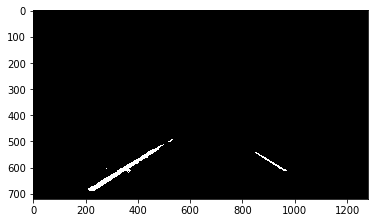

In [78]:
plt.imshow(thresholds[1], cmap='gray')

In [82]:
class Lanes:
    cached_result = None
    cached_lane = None
    last_good_right_curve = None
    last_good_left_curve = None

In [81]:
def pipeline(video):
    print('processing')
    masked = mask_image(video)
    calibration()
    # undistorted_dash = cv2.undistort(masked, cam_mtx, cam_dist, None, cam_mtx)
    undistorted_dash = undistort(masked, False)
    m = cv2.getPerspectiveTransform(get_sourcePoints(), get_destinationPoints())
    m_inverse = cv2.getPerspectiveTransform(get_destinationPoints(), get_sourcePoints())
    image_size = (undistorted_dash.shape[1], undistorted_dash.shape[0])
    warped = cv2.warpPerspective(undistorted_dash, m, image_size, flags=cv2.INTER_LINEAR)
    threshold = get_threshold(warped)

    histogram = np.sum(threshold[threshold.shape[0] // 2:, :], axis=0)
    out_img = np.dstack((threshold, threshold, threshold)) * 255

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0] / 2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    window_height = np.int(threshold.shape[0] / nwindows)
    nonzero = threshold.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    leftx_current = leftx_base
    rightx_current = rightx_base
    margin = 100
    minpix = 50
    left_lane_inds = []
    right_lane_inds = []

    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = threshold.shape[0] - (window + 1) * window_height
        win_y_high = threshold.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0, 255, 0), 2)
        cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0, 255, 0), 2)
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (
        nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (
        nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # this try catch culls out bad frames
    try:
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        # Fit a second order polynomial to each
        Lanes.last_good_right = right_fit
    except:
        return Lanes.cached_result

    ploty = np.linspace(0, threshold.shape[0] - 1, threshold.shape[0])
    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]

    #
    # out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    # out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    ####
    # calculate curves and centerline
    left_curverad, right_curverad = calculate_curves(leftx, lefty, rightx, righty)
    center_calc = get_center_calc(video, left_fitx, right_fitx)

    ###
    warp_zero = np.zeros_like(threshold).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # this is a hamfisted solution to replace curves with extreme values with the previous frame's curve
    if (right_curverad > 5000 or left_curverad > 5000) and Lanes.cached_lane is not None:
        newwarp = Lanes.cached_lane
    else:
        newwarp = cv2.warpPerspective(color_warp, m_inverse, (video.shape[1], video.shape[0]))
        Lanes.cached_lane = newwarp
        Lanes.last_good_right_curve = right_curverad
        Lanes.last_good_left_curve = left_curverad

    result = cv2.addWeighted(video, 1, newwarp, 0.3, 0)
    Lanes.cached_result = result

    text = 'curvature radius: {0} m. '.format((int(left_curverad) + int(right_curverad)) / 2)
    text2 = 'distance from center: {0} m. '.format((np.math.ceil(abs(center_calc) * 100) / 100))
    cv2.putText(result, text, (25, 75), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 0), 2, cv2.LINE_AA)
    cv2.putText(result, text2, (25, 120), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 0), 2, cv2.LINE_AA)

    return result
